### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 22nd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

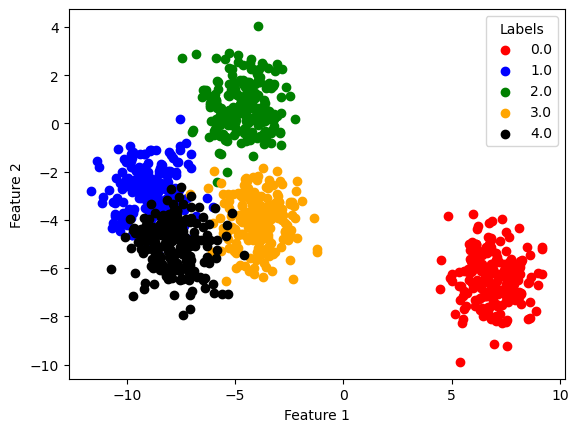

In [7]:
# PROBLEM 1

import numpy as np
import matplotlib.pyplot as plt

filename = "/Users/harvir_d/NEW_repos/astr_8070_s25/coursework/homeworks/hw_data/hw6_data_1.npy" # file path
data = np.load(filename) # easy to load multivariate data if from a numpy file

first_feature = data[:,0] # extracting column at a time
second_feature = data[:,1]
labels=data[:,2]

# Define a unique color mapping for each label
unique_labels = np.unique(labels)  # Get unique label names
color_list = ["red", "blue", "green", "orange","black"]  # Colors assigned to each label
color_map = dict(zip(unique_labels, color_list))  # Create a dictionary mapping labels to colors


fig, ax = plt.subplots()
scatters = [
    ax.scatter(first_feature[labels == label], second_feature[labels == label], c=color_map[label], label=label) 
    for label in unique_labels  # logical indexing to group points by label and associate each point with a color
]

ax.legend(title="Labels")

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.show()


The best bandwidth: 0.4724137931034482


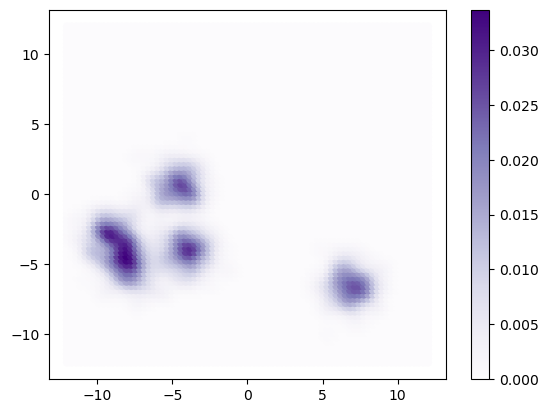

In [10]:
# PROBLEM 2

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

bwrange = np.linspace(0.1, 1.0, 30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) # Try each bandwidth with K-folds
grid.fit(data[:, 0:2])
h_opt = grid.best_params_['bandwidth']
print("The best bandwidth:", h_opt)


kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(data[:, 0:2]) #fit the model to the data

u = v = np.linspace(-12,12,80)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()


/var/folders/5y/r0thn5qs437_z1rk3srjhx3r0000gn/T/ipykernel_21169/2934841732.py:40: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right')


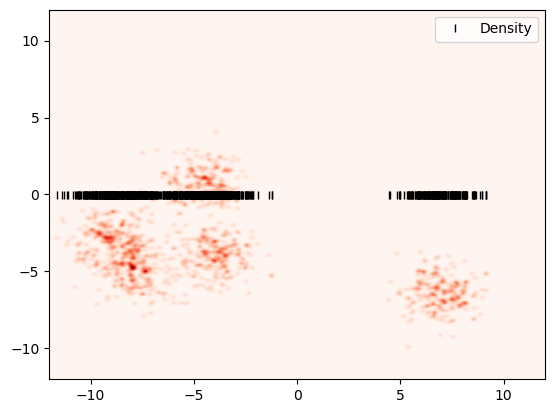

In [23]:
# PROBLEM 3

from astroML.density_estimation import KNeighborsDensity

k = 1000 # number of neighbours
N = 1000 # number of points to normalize density evaluation 

# Create a grid of points in 2D because we have two data features for each sample
feature_1_range = np.linspace(-12, 12, 1000) 
feature_2_range = np.linspace(-12, 12, 1000)  
t1, t2 = np.meshgrid(feature_1_range, feature_2_range)  # Create a mesh grid of points
t = np.vstack([t1.ravel(), t2.ravel()]).T  # Reshape to (1000000, 2) array

# Select the first two columns as the features (this assumes `data` is already defined)
xN = data[:, :2]

# Compute density with KDE
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(xN)  # Fit the KDE model to the data
dens_kde = np.exp(kde.score_samples(t))  # Evaluate density on the grid t

# Reshape dens_kde to match the grid dimensions for plotting
dens_kde = dens_kde.reshape(t1.shape) 

# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(xN)  # Fit the nearest neighbors model to the data
dens_nbrs = nbrs.eval(t) / N  # Evaluate density for 2D grid

# Reshape dens_nbrs to match the grid dimensions for plotting
dens_nbrs = dens_nbrs.reshape(t1.shape) 

# Plot the results
plt.plot(xN[:, 0], -0.005 * np.ones(len(xN)), '|k', label="Density")  # Plot data points themselves

plt.pcolormesh(t1, t2, dens_nbrs, shading='auto', cmap='Blues', label="Nearest Neighbors")  # Nearest Neighbors
plt.pcolormesh(t1, t2, dens_kde, shading='auto', cmap='Reds', label="Kernel Density (h=0.1)")  # Kernel Density

# Add legend to the plot
plt.legend(loc='upper right')
plt.show()





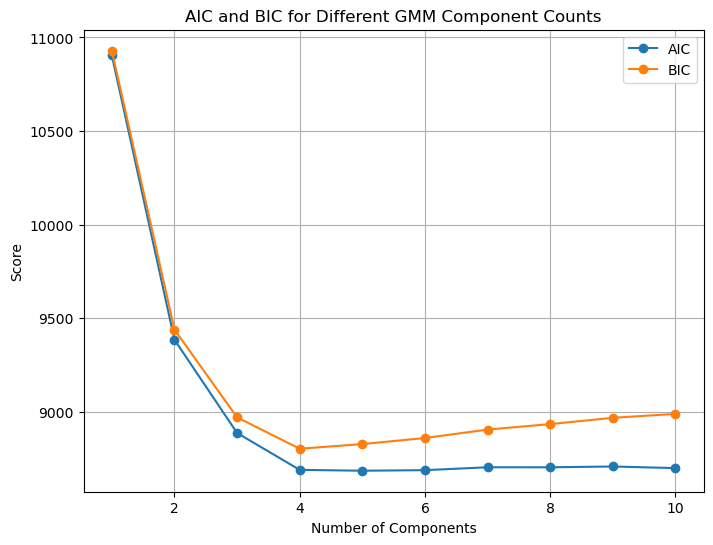

The optimal number of components according to BIC is: 4


In [25]:
# PROBLEM 4

from sklearn.mixture import GaussianMixture

xN = data[:, :2]  # Use the first two columns as features

# Lists to store AIC and BIC values
AIC = []
BIC = []

# Fit Gaussian Mixture Model (GMM) for different numbers of components (1 to 10)
for ii in range(1, 11):
    gmm = GaussianMixture(n_components=ii)  # Fit the GMM with given components
    gmm.fit(xN)  # Fit the model to the data
    
    # Compute and store AIC and BIC for the current model
    AIC.append(gmm.aic(xN))  # AIC value
    BIC.append(gmm.bic(xN))  # BIC value

# Plot the AIC and BIC values as a function of the number of components
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 11), AIC, label='AIC', marker='o')
plt.plot(np.arange(1, 11), BIC, label='BIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('AIC and BIC for Different GMM Component Counts')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Find the optimal number of components according to BIC
optimal_components_bic = np.argmin(BIC) + 1
print(f"The optimal number of components according to BIC is: {optimal_components_bic}")


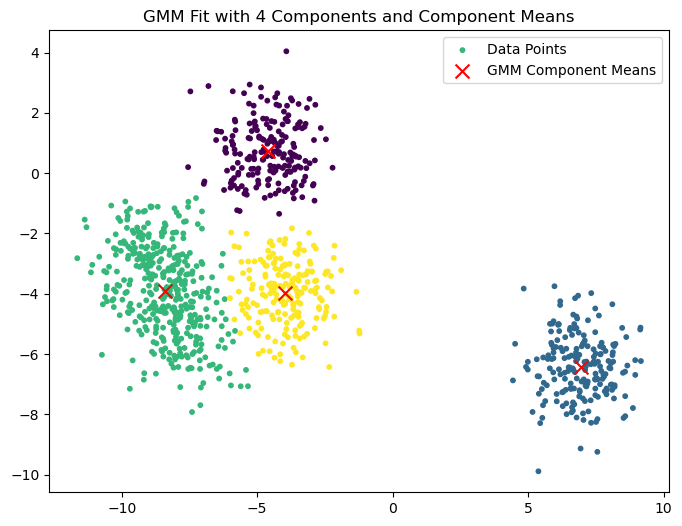

In [28]:
# PROBLEM 4 Continued

# Fit the Gaussian Mixture Model (GMM) with the optimal number of components (4 components)
gmm = GaussianMixture(n_components=4)
gmm.fit(xN)

# Predict the component labels (each point belongs to one of the 4 components)
labels = gmm.predict(xN)

# Get the means of the GMM components
means = gmm.means_

# Plot the data points
plt.figure(figsize=(8, 6))
plt.scatter(xN[:, 0], xN[:, 1], c=labels, cmap='viridis', s=10, label="Data Points")

# Plot the means of the components
plt.scatter(means[:, 0], means[:, 1], c='red', marker='x', s=100, label="GMM Component Means")

plt.title('GMM Fit with 4 Components and Component Means')
plt.legend(loc='best')
plt.show()


In [2]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

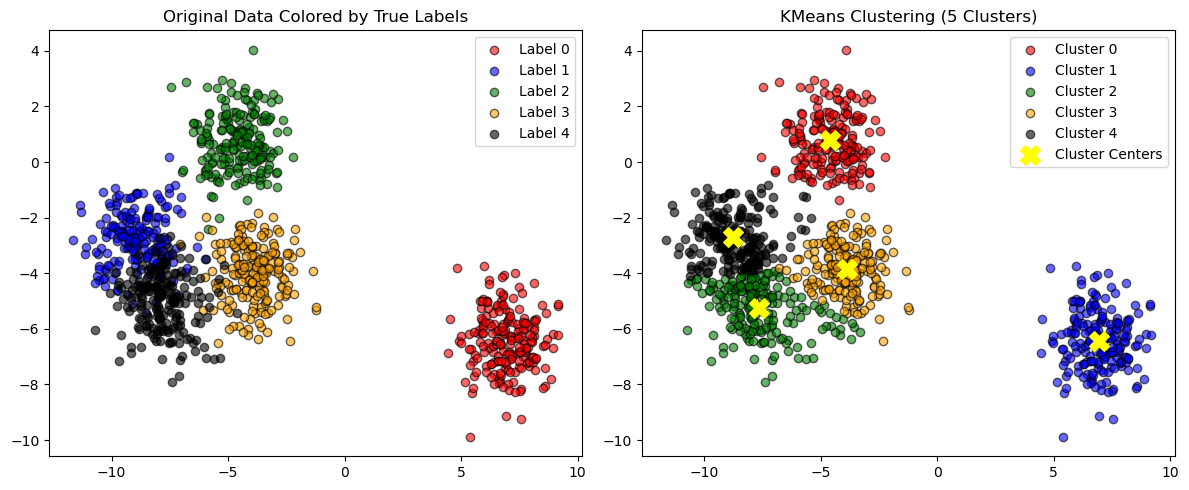

In [19]:
# PROBLEM 5

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


X = data[:, :2]  # Extract the first two columns (features)
true_labels = data[:, 2]  # Extract the true labels

# Define custom colors for both true labels and KMeans clusters
custom_colors = ['red', 'blue', 'green', 'orange', 'black']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale the data

# Apply KMeans clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)  # Fit the model
cluster_centers_scaled = kmeans.cluster_centers_  # Get cluster centers in scaled space
labels = kmeans.predict(X_scaled)  # Predict cluster labels

# Inverse transform the cluster centers to original space
cluster_centers = scaler.inverse_transform(cluster_centers_scaled)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel (a): Original Data Colored by True Labels
for i, color in enumerate(custom_colors):
    mask = (true_labels == i)
    axes[0].scatter(X[mask, 0], X[mask, 1], color=color, edgecolors='k', alpha=0.6, label=f"Label {i}")

axes[0].set_title("Original Data Colored by True Labels")
axes[0].legend()

# Panel (b): Data Colored by KMeans Predicted Labels
for i, color in enumerate(custom_colors):
    mask = (labels == i)
    axes[1].scatter(X[mask, 0], X[mask, 1], color=color, edgecolors='k', alpha=0.6, label=f"Cluster {i}")

# Plot the cluster centers
axes[1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='yellow', marker='X', s=200, label="Cluster Centers")

axes[1].set_title("KMeans Clustering (5 Clusters)")
axes[1].legend()

plt.tight_layout()
plt.show()
